In [1]:
library(DESeq2)
library(pheatmap)
library(ggplot2)
library(dplyr)
library(tidyr)
library(ggplot2)
library(dplyr)
library(tidyr)
library(tibble)
library(apeglm)
library(ggrepel)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [2]:
Chick_counts <- readRDS(file = "Chick_counts.rds")

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



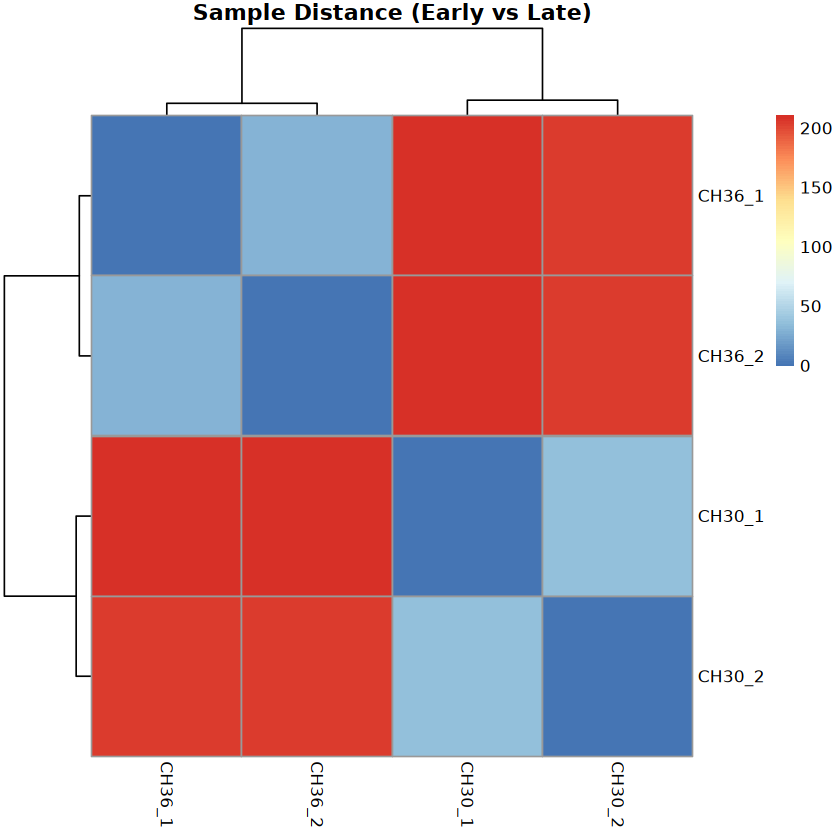

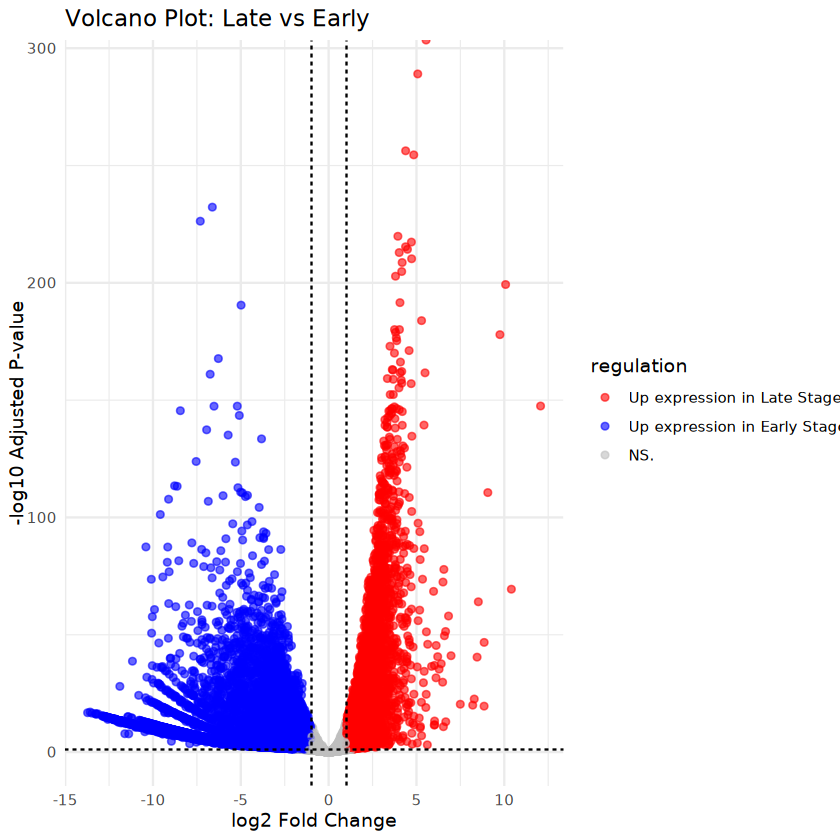

In [3]:
cts <- Chick_counts
orig_stage <- sub("_[12]$", "", colnames(cts))
group     <- factor(ifelse(orig_stage %in% c("CH30"),
                           "Early","Late"),
                    levels = c("Early","Late"))
colData <- data.frame(group=group, row.names=colnames(cts))

dds <- DESeqDataSetFromMatrix(
  countData = cts,
  colData   = colData,
  design    = ~ group
)

keep <- rowSums(counts(dds) >= 10) >= 2
dds  <- dds[keep,]

dds <- DESeq(dds)

rld <- vst(dds, blind=FALSE)
mat <- assay(rld)
# 热图
dist_mat <- as.matrix(dist(t(mat)))
rownames(dist_mat) <- colnames(dist_mat) <- colnames(mat)
pheatmap(dist_mat,
         clustering_distance_rows = dist(t(mat)),
         clustering_distance_cols = dist(t(mat)),
         main="Sample Distance (Early vs Late)")

resLFC <- lfcShrink(dds,coef = "group_Late_vs_Early",
                    type     = "apeglm")

res_df <- as.data.frame(resLFC)
res_df$gene <- rownames(res_df)

res_df$regulation <- "NS."

res_df$regulation[
  res_df$padj < 0.05 & res_df$log2FoldChange >  1 
] <- "Up expression in Late Stage"

res_df$regulation[
  res_df$padj < 0.05 & res_df$log2FoldChange < -1
] <- "Up expression in Early Stage"

res_df$regulation <- factor(
  res_df$regulation,
  levels = c("Up expression in Late Stage", "Up expression in Early Stage", "NS.")
)

ggplot(res_df, aes(x=log2FoldChange, y=-log10(padj))) +
  geom_point(aes(color=regulation), alpha=0.6, size=1.5) +
  scale_color_manual(values = c(
      "Up expression in Late Stage" = "red",
      "Up expression in Early Stage" = "blue",
      "NS." = "grey"
    )) +
  geom_vline(xintercept=c(-1,1), linetype="dashed") +
  geom_hline(yintercept=-log10(0.05), linetype="dashed") +
  labs(title="Volcano Plot: Late vs Early",
       x="log2 Fold Change",
       y="-log10 Adjusted P-value") +
  theme_minimal()

In [4]:
marker_dt <- readRDS(file = "./markers.rds")
marker_genes <- unique(marker_dt$V2)

Warning message in geom_text_repel(data = top50, aes(x = log2FoldChange, y = -log10(padj), :
“Ignoring unknown parameters: `fill` and `label.size`”


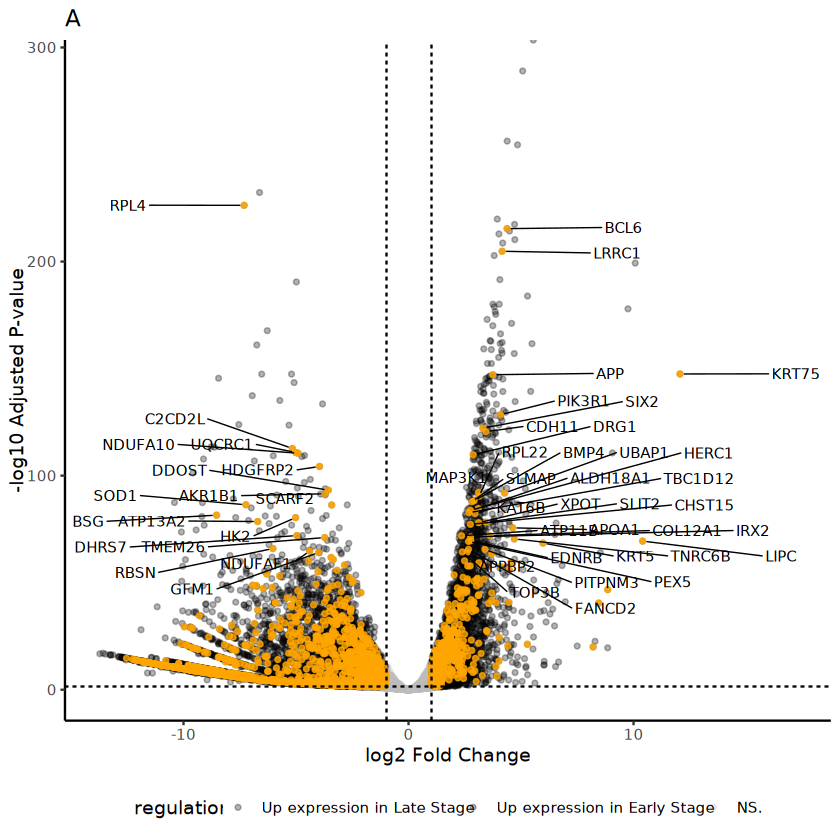

In [5]:
res_df$dist_from_origin <- with(
  res_df,
  sqrt(log2FoldChange^2 + (-log10(padj))^2)
)
res_df$is_marker <- res_df$gene %in% marker_genes

top50 <- res_df[res_df$is_marker & res_df$regulation != "NS", ]
top50 <- top50[order(top50$dist_from_origin, decreasing=TRUE), ]
top50 <- head(top50, 50)

x_rng   <- range(res_df$log2FoldChange, na.rm = TRUE)
x_width <- diff(x_rng)
nudg_x  <- 0.2 * x_width

y_vals  <- -log10(res_df$padj+1)
y_rng   <- range(y_vals, na.rm = TRUE)
y_width <- diff(y_rng)
nudg_y  <- 0.2 * y_width

top50$nudge_x <- ifelse(top50$log2FoldChange > 0,  nudg_x, -nudg_x)
top50$nudge_y <- nudg_y

res_df$is_marker <- res_df$gene %in% marker_genes

p <- ggplot(res_df, aes(x = log2FoldChange, y = -log10(padj))) +
  geom_point(aes(color = regulation), alpha = 0.3, size = 1) +
  scale_color_manual(
    values = c(
      "Up expression in Late Stage"  = "black",
      "Up expression in Early Stage" = "black",
      "NS."                     = "grey"
    )
  ) 

p <- p + geom_point(
  data = subset(res_df, is_marker & regulation != "NS."),
  aes(x = log2FoldChange, y = -log10(padj)),
  color = "orange",
  size = 1, alpha =0.8
)
p <- p +  geom_text_repel(
    data = top50,
    aes(x = log2FoldChange, y = -log10(padj), label = gene),
    nudge_x = top50$nudge_x,
    nudge_y = top50$nudge_y, 
    #direction     = "y",
    force         = 2,
    box.padding   = 0.3,
    point.padding = 0.2,
    segment.size  = 0.3,
    size          = 3,
    fill          = "white",          
    label.size    = 0.2,              
    max.overlaps = 1000
  ) + 
  geom_vline(xintercept = c(-1, 1), linetype = "dashed") +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
  labs(
    title = "A",
    x = "log2 Fold Change",
    y = "-log10 Adjusted P-value"
  ) +
  theme_classic() + theme(legend.position="bottom")

print(p)

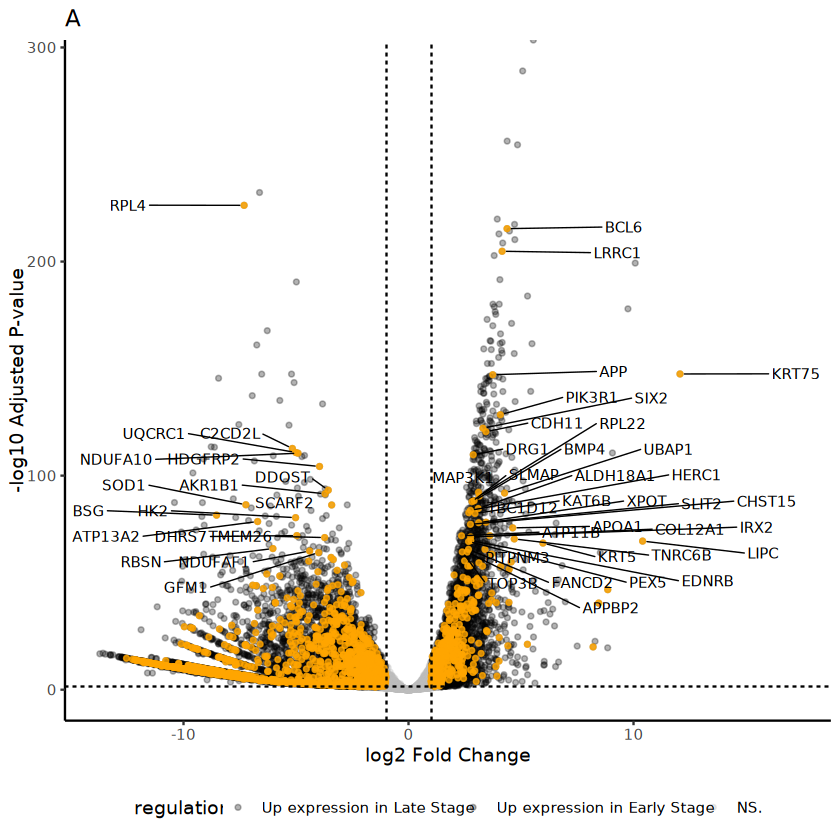

In [6]:
#pdf("./Volacano.plot.pdf",w=5,h=5)
p
#dev.off()

In [7]:
res_df$RGB <- res_df$gene %in% marker_genes
contingency_table <- table(
  RGB = res_df$RGB,
  Significant = res_df$regulation != "NS."
)

print(contingency_table)

fisher_result <- fisher.test(contingency_table)
print(fisher_result)

       Significant
RGB     FALSE TRUE
  FALSE  5346 9319
  TRUE    695 1455

	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.0001902
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.089611 1.324614
sample estimates:
odds ratio 
  1.200956 

